In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from collections import defaultdict

In [16]:
# assumed step size between m3 points
STEPSIZE = 0.04

# boundaries for wavelengths, outside of which to ignore/truncate data
WL_MIN = 0.46
WL_MAX = 2.94

# TODO (in order of priority)
# !save binned xy pairs and cubic spline xy pairs to CSVs
# convert to python script file to run from cli
# modify to read in a folder of csvs and a target to bin to (m3 in original case)
# use variable (0.02 vs 0.04) step size based on micron range
# rename + recolor graph legend
# save graphs into subfolders based on lunar_analog_spectra folders (Iceland_JB501C graph goes into /Glass_volcanics)
# prompt user whether to save graphs

# step size until 1.57 microns
# STEPSIZE_PRE = 0.02
# step size after 1.57 microns 
# STEPSIZE_POST = 0.04

In [17]:
# boundaries: 
# m^3
# 0.46 microns - 460 nanometers
# 3 microns  - 3000 nanometers
# trailblazer
# 0.6 microns - 600 nanometers
# 3.6 microns - 3600 nanometers

# bin methods
# 1:1, cubic spline over 84 points (check for uniform step size)

In [18]:
m3 = pd.read_csv('m3 original data.csv')
# lab = pd.read_csv('lunar_analog_spectra/Pyroxene lab spectra FDL/USGS augite WS592.csv')
# lab = pd.read_csv('lunar_analog_spectra/Pyroxene lab spectra FDL/USGS orthoclase spliced.csv')
lab = pd.read_csv('lunar_analog_spectra/Glass_volcanics/Iceland_JB501C.csv')

In [19]:
m3.head()

,Step Size,Wavelength (µm),"Strip 325 330, morning/midday, lat 30 - Back","Strip 325 330, morning/midday, lat 30","Strip 325 330, morning/midday, lat 0 - Back","Strip 325 330, morning/midday, lat 0","Strip 325 330, morning/midday, lat -30 - Back","Strip 325 330, morning/midday, lat -30","Strip 295 305, morning/midday, lat 60 - Back","Strip 295 305, morning/midday, lat 60",...,"Strip 295 305, morning/midday, lat 30","Strip 295 305, morning/midday, lat 0 - Back","Strip 295 305, morning/midday, lat 0","Strip 295 305, morning/midday, lat -30 - Back","Strip 295 305, morning/midday, lat -30","Strip 240 250, morning/midday, lat 60 - Back","Strip 240 250, morning/midday, lat 60","Strip 240 250, morning/midday, lat 30 - Back","Strip 240 250, morning/midday, lat 30","Back = Strip 240 250, morning/midday, lat -30"
0,0.03993,0.46099,-0.020805,0.73383,0.007319,0.76196,0.20118,0.95581,0.15679,0.91143,...,0.89989,0.030394,0.78503,0.086746,0.84138,2.282000e-01,9.828400e-01,0.077972,0.83261,0.75464
1,0.03992,0.50092,-0.070086,0.84618,-0.051590,0.86467,0.16634,1.08260,0.14971,1.06600,...,1.04090,-0.025042,0.89122,0.049061,0.96532,3.400000e+38,3.400000e+38,0.069836,0.98610,0.91626
2,0.03992,0.54084,-0.110560,0.84613,-0.089018,0.86767,0.14826,1.10500,0.11678,1.07350,...,1.00360,-0.075746,0.88095,0.031726,0.98842,3.400000e+38,3.400000e+38,0.034699,0.99139,0.95669
3,0.03993,0.58076,-0.110600,0.86259,-0.090397,0.88279,0.12067,1.09390,0.10629,1.07950,...,0.99137,-0.109050,0.86414,0.028246,1.00140,9.577900e-02,1.069000e+00,0.031362,1.00450,0.97319
4,0.03992,0.62069,-0.099762,0.85225,-0.073678,0.87833,0.11705,1.06910,0.10626,1.05830,...,0.98712,-0.091118,0.86089,0.035011,0.98702,1.027800e-01,1.054800e+00,0.037839,0.98985,0.95201


In [20]:
x_m3 = (m3['Wavelength (µm)']).tolist()
x_m3 = [f"{wl:.5f}" for wl in x_m3]
print(f"# of m^3 wavelengths: {len(x_m3)}, first and last: {x_m3[0], x_m3[-1]}")

# of m^3 wavelengths: 84, first and last: ('0.46099', '2.93630')


In [21]:
# lab.head()

In [22]:
lab['Wavelength (µm)'] = lab['Wavelength (nm)']/1000
lab = lab.set_index('Wavelength (µm)')

y_column_label = lab.columns[1]
x_raw = list(lab.index)
y_raw = list(lab[y_column_label])

print(f"first and last raw x,y pairs\n{(x_raw[0], y_raw[0])}\n{(x_raw[-1], y_raw[-1])}")

first and last raw x,y pairs
(0.32, 0.01734)
(4.0001, 0.11886)


In [23]:
# y_column_label

In [24]:
# bins stored as numerical strings
binned_raw = defaultdict(list)
for x in x_m3:
    binned_raw[x] = []
len(binned_raw)

84

In [25]:
# append points to bin with wavelength within half of stepsize
# average points across list
# precondition: wavelengths are sorted in ascending order

binCounter = 0
for x,y in zip(x_raw, y_raw):
    if x < WL_MIN or x > WL_MAX: continue

    lbound = float(x_m3[binCounter]) - STEPSIZE/2
    rbound = float(x_m3[binCounter]) + STEPSIZE/2

    # while point doesn't fit into current bin
    # increment binCounter unless not found
    while x > rbound: 
        if binCounter + 1 < len(x_m3):
            binCounter += 1

            # update bin bounds
            lbound = float(x_m3[binCounter]) - STEPSIZE/2
            rbound = float(x_m3[binCounter]) + STEPSIZE/2
        else:
            print(f"Point {x, y} within WL MINMAX range {WL_MIN, WL_MAX} but no bin found, last {lbound, rbound}")
            break
    
    # add point to bin
    binned_raw[x_m3[binCounter]].append((x,y))
    
    # print(f"x {x}, band center {nextbin}, upper bound of bin {nextbin + STEPSIZE/2}")

print(f"bin index: {binCounter}, input list size: {len(x_raw)}")

bin index: 83, input list size: 1338


In [26]:
# average all wavelength values in the same bin

y_avg = []
x_avg = []
for count, bin in enumerate(binned_raw):
    if len(binned_raw[bin]) == 0:
        x_avg.append(bin)
        y_avg.append(-1)
        print(f"Empty bin at {bin}")
        continue

    # average over all raw reflectance values
    avgx = 0
    avgy = 0
    for x,y in binned_raw[bin]:
        avgx += x
        avgy += y
    avgx /= len(binned_raw[bin])
    avgy /= len(binned_raw[bin])

    y_avg.append(avgy)
    x_avg.append(avgx)

print(f"# of average reflectance values {len(y_avg)}, first and last averaged points {[(x_avg[0], y_avg[0]), (x_avg[-1], y_avg[-1])]}")

# of average reflectance values 84, first and last averaged points [(0.47000000000000003, 0.063528), (2.9280785714285713, 0.03454857142857143)]


In [27]:
from scipy.interpolate import CubicSpline

spline_points = len(x_avg)
cs_avg = CubicSpline(x_avg, y_avg)

x_spline_avg = np.linspace(min(x_avg), max(x_avg), spline_points)
y_spline_avg = cs_avg(x_spline_avg)

# len(x_spline_avg), len(y_spline_avg)

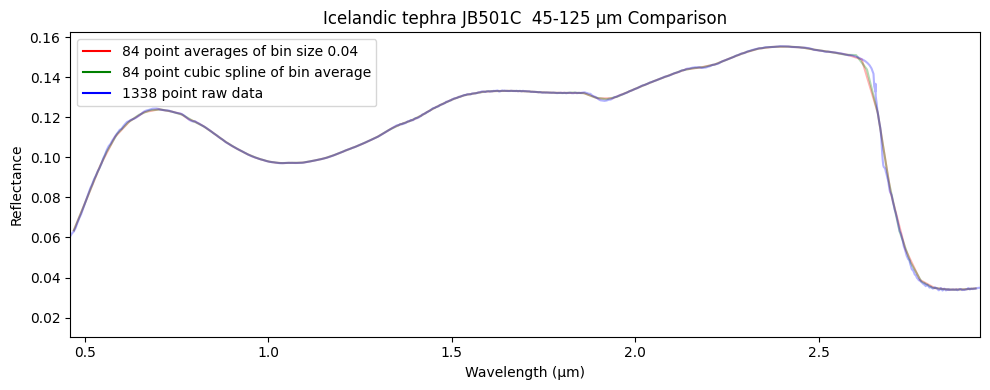

In [28]:
plot.rcParams['figure.figsize'] = (10,4)

ax = sns.lineplot(
    x = x_avg,
    y = y_avg,
    label = f"{len(x_avg)} point averages of bin size 0.04",
    color = "red",
)


ax = sns.lineplot(
    x = x_spline_avg,
    y = y_spline_avg,
    label = f"{spline_points} point cubic spline of bin average",
    color = "green",
)

ax = sns.lineplot(
    x = x_raw,
    y = y_raw,
    label = f"{len(x_raw)} point raw data",
    color = 'blue',
)

for line in ax.lines:
    line.set_alpha(0.3)


plot.title(f"{y_column_label} Comparison")
plot.xlabel('Wavelength (µm)')
plot.ylabel('Reflectance')

plot.xlim(WL_MIN, WL_MAX)
plot.tight_layout()
# plot.savefig(f'graphs/{y_column_label} Comparison.png', bbox_inches='tight', dpi = 1000, transparent = False)
plot.show()